# COGS 118B Project

### By Miguel Garcia and Janina Schuhmacher


In [1]:
import sklearn.metrics as metrics
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import check_X_y
import warnings
warnings.filterwarnings("ignore")

#name the columns
colnames=['age', 'workclass',  'fnlwgt', 'education', 
          'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'capital-gain', 
          'capital-loss', 'hours-per-week', 'native-country', 'income']

# read data in df
df = pd.read_csv('adult.data', names=colnames, header=None)


In [2]:
# display df header
data_top = df.head()   
data_top

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Drop null values

In [3]:
df.shape #before dropping nulls

(32561, 15)

In [4]:
for i in colnames:   #ignores all null values
    df = df[(df[i] != ' ?')]

In [5]:
df.shape #after dropping nulls

(30162, 15)

### Keep income only from Americans since it represents most of the data and remove trailing white space

In [6]:
#df['native-country'].value_counts()

In [7]:
df = df[(df['native-country'] == ' United-States')]
df = df.reset_index()

In [8]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [9]:
df.shape

(27504, 16)

### Visualize the distribution of the categorical features

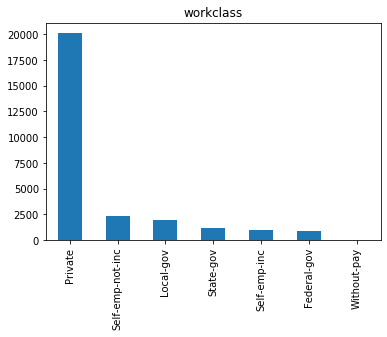

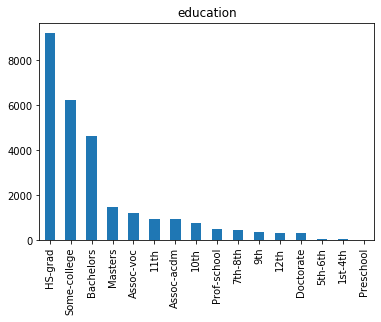

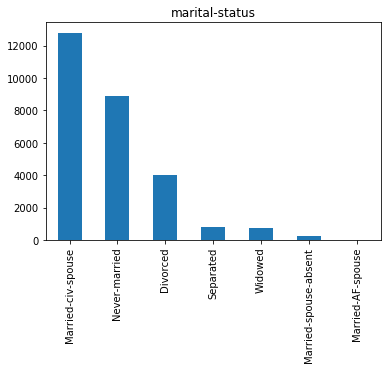

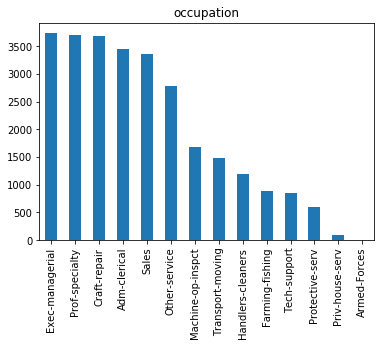

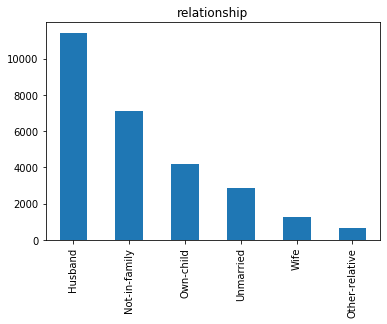

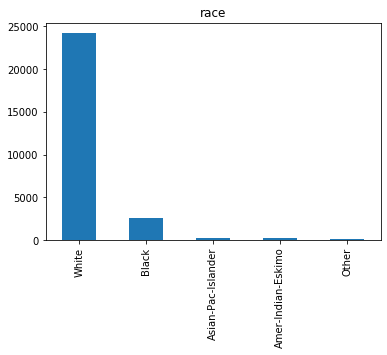

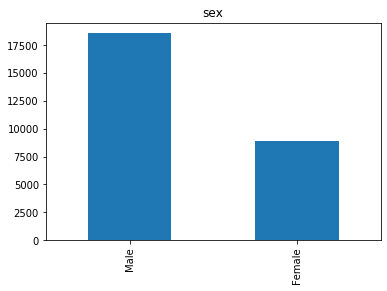

In [10]:
# plotting the frequency of the values

string_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

for col in string_columns: 
    fig, ax = plt.subplots()
    df[col].value_counts().plot(ax=ax, kind='bar', title = col)

## Visualize the continuous feautures

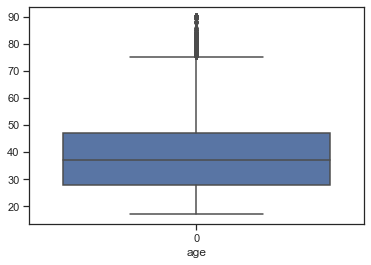

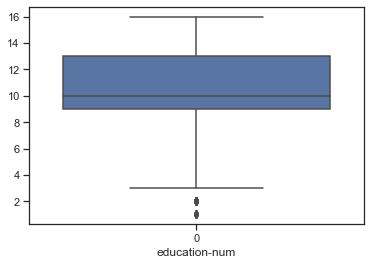

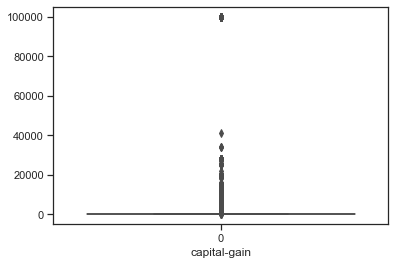

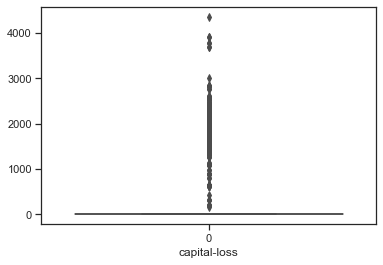

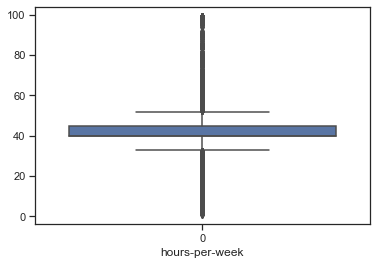

In [11]:
# to do
sns.set(style="ticks", color_codes=True)

string_columns = ['age','education-num','capital-gain',
             'capital-loss','hours-per-week']

for col in string_columns: 
    fig, ax = plt.subplots()
    ax = sns.boxplot(data=df[col]).set(
    xlabel=col
)


### One hot encode

In [12]:
new_df = df[['age','fnlwgt','education-num','capital-gain',
             'capital-loss','hours-per-week']]  #non-categorical features (some are not important)
one_hot_cols = ['workclass', 'marital-status',
                'occupation','relationship','race']  #categorical features we care about
for i in one_hot_cols:  #for every categorical feature, onehot encode it
    new_df = new_df.join(pd.get_dummies(df[i],prefix = i))
    
new_df['income'] = pd.DataFrame((df['income'] == '>50K').astype(int))  #if greater than 50k 1 else 0 for label

In [13]:
for i in new_df.columns: #print new columns
    print(i)

age
fnlwgt
education-num
capital-gain
capital-loss
hours-per-week
workclass_Federal-gov
workclass_Local-gov
workclass_Private
workclass_Self-emp-inc
workclass_Self-emp-not-inc
workclass_State-gov
workclass_Without-pay
marital-status_Divorced
marital-status_Married-AF-spouse
marital-status_Married-civ-spouse
marital-status_Married-spouse-absent
marital-status_Never-married
marital-status_Separated
marital-status_Widowed
occupation_Adm-clerical
occupation_Armed-Forces
occupation_Craft-repair
occupation_Exec-managerial
occupation_Farming-fishing
occupation_Handlers-cleaners
occupation_Machine-op-inspct
occupation_Other-service
occupation_Priv-house-serv
occupation_Prof-specialty
occupation_Protective-serv
occupation_Sales
occupation_Tech-support
occupation_Transport-moving
relationship_Husband
relationship_Not-in-family
relationship_Other-relative
relationship_Own-child
relationship_Unmarried
relationship_Wife
race_Amer-Indian-Eskimo
race_Asian-Pac-Islander
race_Black
race_Other
race_Whit

In [14]:
new_df.head(10)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,37,284582,14,0,0,40,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
5,52,209642,9,0,0,45,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,31,45781,14,14084,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
7,42,159449,13,5178,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
8,37,280464,10,0,0,80,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
9,23,122272,13,0,0,30,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [15]:
new_df.shape   #shape after all cleaning

(27504, 46)

In [16]:
new_df = new_df.reset_index()

In [17]:
new_df.columns[1:46]

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'rela

### Permutate/Shuffle the dataframe before applying algorithms

In [18]:
new_df = new_df.reindex(np.random.permutation(new_df.index))
new_df.head(10)

,index,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
4174,4174,38,203836,3,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7910,7910,38,204527,9,0,0,50,0,0,1,...,0,0,0,0,0,0,0,0,1,0
19596,19596,24,62952,9,0,0,40,0,0,1,...,0,1,0,0,0,0,0,0,1,0
18653,18653,41,185057,9,0,0,40,0,1,0,...,0,0,1,0,0,0,0,0,1,0
15677,15677,30,210906,9,0,0,40,0,0,1,...,1,0,0,0,0,0,0,0,1,0
2586,2586,28,90196,13,0,0,45,0,0,1,...,0,0,0,0,0,0,0,0,1,1
26564,26564,30,54318,7,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3850,3850,20,120601,9,0,0,40,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1381,1381,52,158993,9,0,0,38,0,0,1,...,1,0,0,0,0,0,1,0,0,0
14016,14016,40,391736,11,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Drop final weight (we don't need it)

In [19]:
new_df.drop(columns = ['fnlwgt'],inplace = True)
new_df.head(10)

,index,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,income
4174,4174,38,3,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7910,7910,38,9,0,0,50,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
19596,19596,24,9,0,0,40,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
18653,18653,41,9,0,0,40,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
15677,15677,30,9,0,0,40,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2586,2586,28,13,0,0,45,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
26564,26564,30,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3850,3850,20,9,0,0,40,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
1381,1381,52,9,0,0,38,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
14016,14016,40,11,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Get indexes for each individual feature and their respective names

In [20]:
ranges = [[1,2],[2,3],[3,4],[4,5],[5,6],[6,13],[13,20],[20,34],[34,40],[40,45],[1,45]]
columns = ['Age', 'Education','Capital Gain','Capital Loss','Hours Per Week',
           'Workclass','Marital Status','Occupation','Relationship','Race' ,'All Columns']

### Function to return results for each classifier

In [21]:
def return_results(clf,string,is_svm,is_dummy,i):
    print('---------- Results Summary for',string,'for the column:',columns[i],'----------')
    print()
    X = sc.fit_transform(new_df.iloc[:,ranges[i][0]:ranges[i][1]])  #apply standard scaler
    
    X_train = X[:num_training]   #training features 80% of data
    X_test = X[num_training:]    #testing features 20% of data
    Y_train = Y[:num_training]   #training labels 80% of data
    Y_test = Y[num_training:]   #testing labels 20% of data
    start_time = time.time()  #start counting time
    clf.fit(X_train, Y_train) #train algorithm
    scores = 0
    if is_svm == True:  #if it is an svm we do cross validation
        scores = cross_val_score(clf, X_test, Y_test, cv=5)  #5 cross validation folds for accuracy
        scores = max(scores)
    elif is_dummy == True:   #if it is dummy we calculate accuracy differently
        X_trainc, Y_trainc = \
                         check_X_y(X=X_train, y=Y_train)
        clf.fit(X=X_trainc, y=Y_trainc)
        scores = clf.score(X_test,Y_test)
                
    else:
        scores = clf.score(X_test,Y_test) #otherwise use default function
        
    print(str(time.time() - start_time)+" seconds for ", string, " to train") #end time counting and print
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get train accuracy of: ',clf.score(X_train,Y_train))  # train accuracy
    print('Using' ,columns[i],'as a predictor for ' ,string,
          ' we get test accuracy of: ',scores)  # calculate accuracy using 20%
    print()
    
    #confusion matrix
    cf_matrix = pd.DataFrame(confusion_matrix(Y_test, clf.predict(X_test)),index = ["True <50k", "True >50k"],
                columns = ["Pred <50k", "Pred >50k"])
    print('Confusion Matrix: ')
    print(cf_matrix)
    print()
    
    #f1 score
    score_f1 = f1_score(Y_test, clf.predict(X_test))
    print('F1-score is:',score_f1)

    #plot ROC
    fpr, tpr, thr = metrics.roc_curve(Y_test, clf.predict(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic Curve for ' + str(string))
    plt.plot(fpr, tpr)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print()

### Classifiers we will use with different initializations

In [22]:
#classifiers we will use with different initializations
classifiers = [SVC(kernel = 'linear',gamma ='auto',random_state = 50)]
classifiers.append(SVC(kernel = 'sigmoid',gamma ='auto',random_state = 50))
classifiers.append(SVC(kernel = 'rbf',gamma ='auto',random_state = 50)) #radial basis function kernel
classifiers.append(MLPClassifier(solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(MLPClassifier(activation = 'logistic',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(MLPClassifier(activation = 'tanh',solver='lbfgs', alpha=10,hidden_layer_sizes=(5, 2)))
classifiers.append(DummyClassifier(strategy="most_frequent")) #“most_frequent”: always predicts the most frequent label in the training set.

### Name of the Classifiers

In [23]:
names = ['SVM with Linear Kernel','SVM with Sigmoid Kernel','SVM with Radial Basis Function Kernel',
        'Neural Network with ReLU activation','Neural Network with Logistic Sigmoid activation',
        'Neural Network with tanh activation', 'Dummy Classifier that predicts most frequent']

### Calculate accuracy per each feature

--------------- Returning Algorithm Results Summary for the feature: Age ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Age ----------

3.951352119445801 seconds for  SVM with Linear Kernel  to train
Using Age as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7437622142435123
Using Age as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


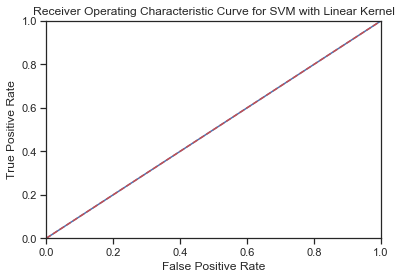


---------- Results Summary for SVM with Sigmoid Kernel for the column: Age ----------

6.094411134719849 seconds for  SVM with Sigmoid Kernel  to train
Using Age as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.6777257646684544
Using Age as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.6811989100817438

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3357        787
True >50k        963        394

F1-score is: 0.3104806934594169


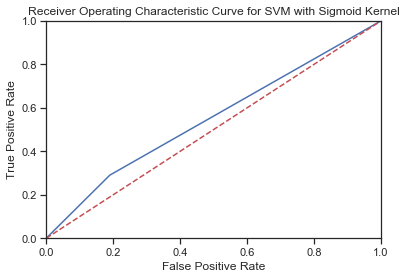


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Age ----------

5.4040467739105225 seconds for  SVM with Radial Basis Function Kernel  to train
Using Age as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7437622142435123
Using Age as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


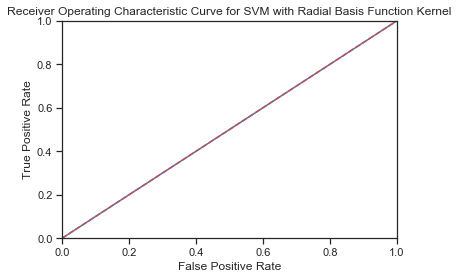


---------- Results Summary for Neural Network with ReLU activation for the column: Age ----------

0.43024587631225586 seconds for  Neural Network with ReLU activation  to train
Using Age as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7437622142435123
Using Age as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


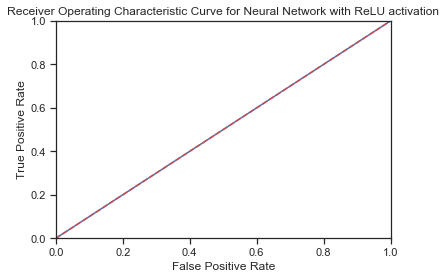


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Age ----------

0.2778172492980957 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7437622142435123
Using Age as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


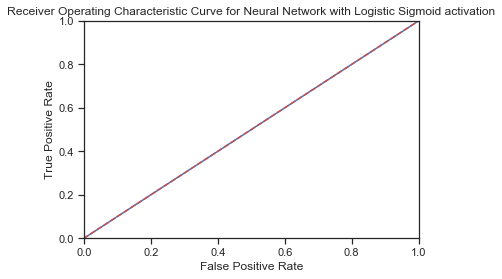


---------- Results Summary for Neural Network with tanh activation for the column: Age ----------

0.35869598388671875 seconds for  Neural Network with tanh activation  to train
Using Age as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7437622142435123
Using Age as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


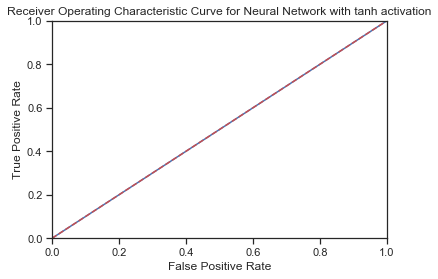


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Age ----------

0.0036361217498779297 seconds for  Dummy Classifier that predicts most frequent  to train
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7437622142435123
Using Age as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


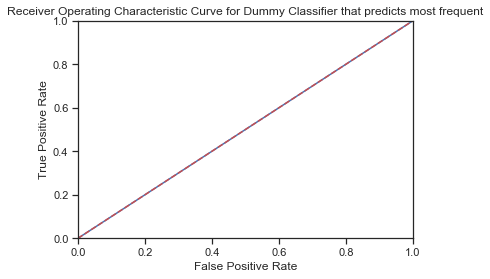


--------------- Returning Algorithm Results Summary for the feature: Education ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Education ----------

3.7445881366729736 seconds for  SVM with Linear Kernel  to train
Using Education as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7437622142435123
Using Education as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


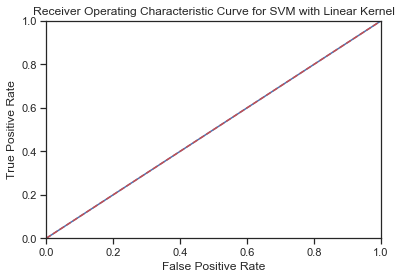


---------- Results Summary for SVM with Sigmoid Kernel for the column: Education ----------

7.195817947387695 seconds for  SVM with Sigmoid Kernel  to train
Using Education as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.6303685861018952
Using Education as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.6454545454545455

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       2967       1177
True >50k        844        513

F1-score is: 0.3367246471939612


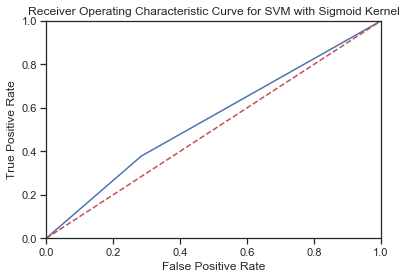


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Education ----------

6.6399500370025635 seconds for  SVM with Radial Basis Function Kernel  to train
Using Education as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.766713629959551
Using Education as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.78

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3985        159
True >50k       1079        278

F1-score is: 0.30992196209587514


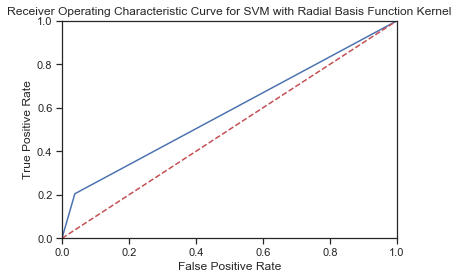


---------- Results Summary for Neural Network with ReLU activation for the column: Education ----------

0.06533575057983398 seconds for  Neural Network with ReLU activation  to train
Using Education as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7437622142435123
Using Education as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


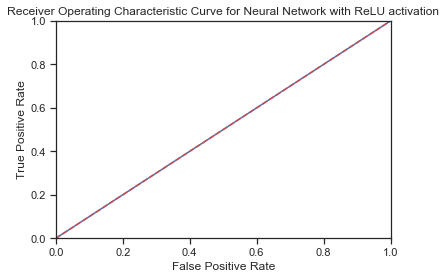


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Education ----------

0.22480082511901855 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.766713629959551
Using Education as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7749500090892565

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3985        159
True >50k       1079        278

F1-score is: 0.30992196209587514


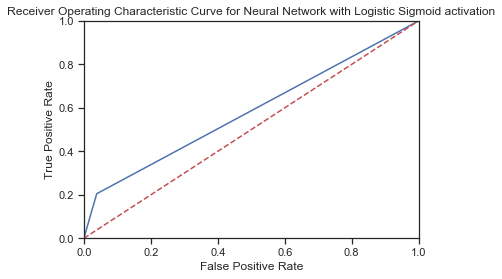


---------- Results Summary for Neural Network with tanh activation for the column: Education ----------

0.18382573127746582 seconds for  Neural Network with tanh activation  to train
Using Education as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.766713629959551
Using Education as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7749500090892565

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3985        159
True >50k       1079        278

F1-score is: 0.30992196209587514


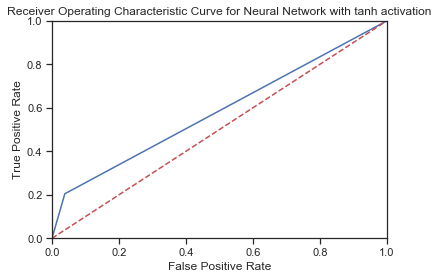


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Education ----------

0.0019769668579101562 seconds for  Dummy Classifier that predicts most frequent  to train
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7437622142435123
Using Education as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


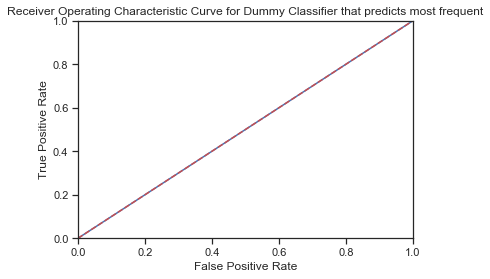


--------------- Returning Algorithm Results Summary for the feature: Capital Gain ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Capital Gain ----------

2.0478010177612305 seconds for  SVM with Linear Kernel  to train
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7850293141844294
Using Capital Gain as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7910990009082652

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4081         63
True >50k       1112        245

F1-score is: 0.2942942942942943


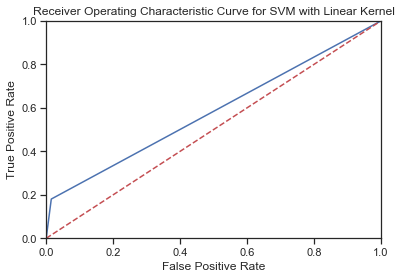


---------- Results Summary for SVM with Sigmoid Kernel for the column: Capital Gain ----------

3.700446128845215 seconds for  SVM with Sigmoid Kernel  to train
Using Capital Gain as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7605326546380039
Using Capital Gain as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7745454545454545

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3971        173
True >50k       1126        231

F1-score is: 0.26235093696763206


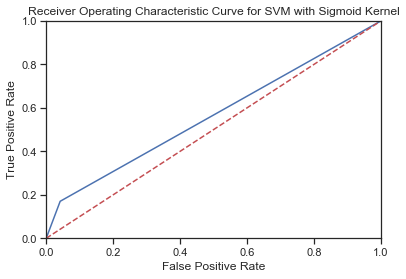


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Capital Gain ----------

2.948328971862793 seconds for  SVM with Radial Basis Function Kernel  to train
Using Capital Gain as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7884833886288234
Using Capital Gain as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7929155313351499

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4130         14
True >50k       1141        216

F1-score is: 0.2722117202268431


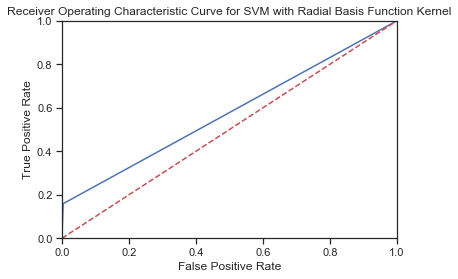


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Gain ----------

0.3392350673675537 seconds for  Neural Network with ReLU activation  to train
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.791255737853929
Using Capital Gain as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7918560261770587

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4127         17
True >50k       1128        229

F1-score is: 0.2857142857142857


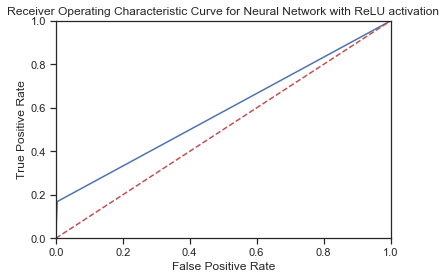


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Gain ----------

0.2704639434814453 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7893014588919692
Using Capital Gain as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7891292492274132

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4112         32
True >50k       1128        229

F1-score is: 0.28306551297898636


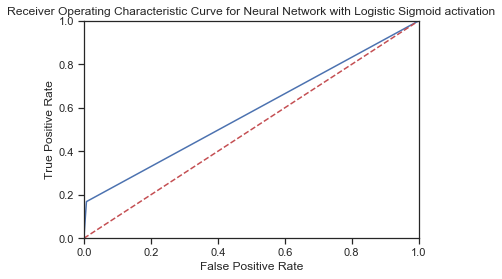


---------- Results Summary for Neural Network with tanh activation for the column: Capital Gain ----------

0.23533916473388672 seconds for  Neural Network with tanh activation  to train
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7879380084533927
Using Capital Gain as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7894928194873659

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4127         17
True >50k       1141        216

F1-score is: 0.27169811320754716


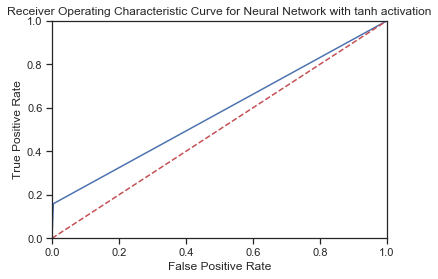


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Gain ----------

0.0025701522827148438 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7437622142435123
Using Capital Gain as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


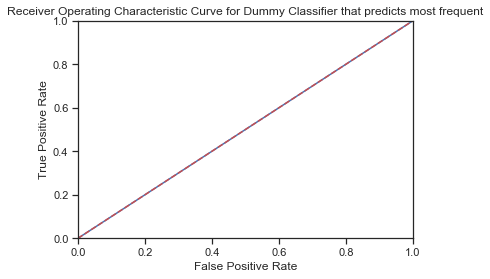


--------------- Returning Algorithm Results Summary for the feature: Capital Loss ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Capital Loss ----------

2.233366012573242 seconds for  SVM with Linear Kernel  to train
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7459437349452347
Using Capital Loss as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7638510445049954

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4041        103
True >50k       1218        139

F1-score is: 0.1738586616635397


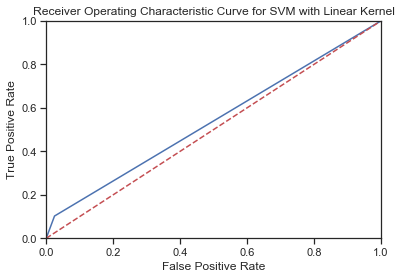


---------- Results Summary for SVM with Sigmoid Kernel for the column: Capital Loss ----------

4.110970973968506 seconds for  SVM with Sigmoid Kernel  to train
Using Capital Loss as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7436258691996546
Using Capital Loss as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7638510445049954

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4038        106
True >50k       1248        109

F1-score is: 0.138676844783715


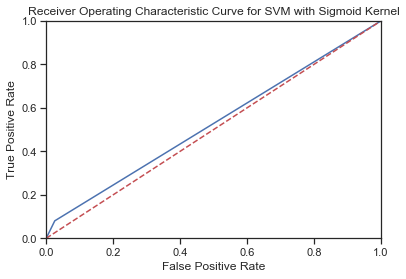


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Capital Loss ----------

3.1933047771453857 seconds for  SVM with Radial Basis Function Kernel  to train
Using Capital Loss as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.758805617415807
Using Capital Loss as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7747502270663034

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4116         28
True >50k       1232        125

F1-score is: 0.16556291390728478


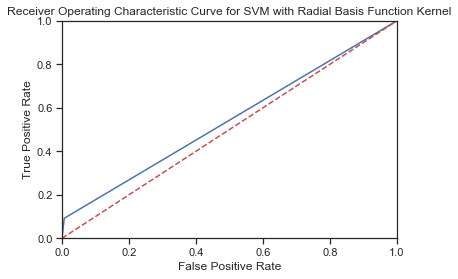


---------- Results Summary for Neural Network with ReLU activation for the column: Capital Loss ----------

0.5392508506774902 seconds for  Neural Network with ReLU activation  to train
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7578966504567559
Using Capital Loss as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7705871659698237

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4109         35
True >50k       1227        130

F1-score is: 0.17082785808147177


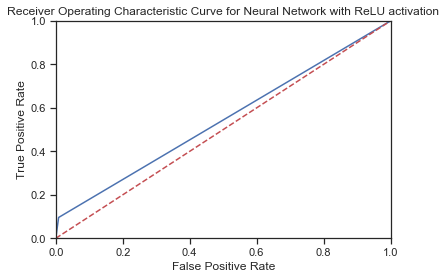


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Capital Loss ----------

0.31484484672546387 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7575330636731354
Using Capital Loss as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7705871659698237

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4109         35
True >50k       1227        130

F1-score is: 0.17082785808147177


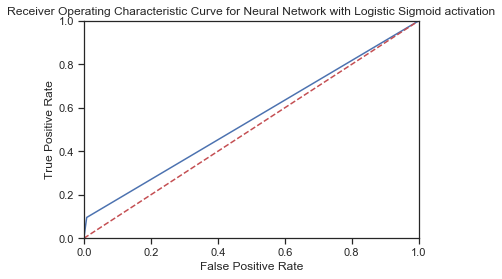


---------- Results Summary for Neural Network with tanh activation for the column: Capital Loss ----------

0.42411303520202637 seconds for  Neural Network with tanh activation  to train
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7575330636731354
Using Capital Loss as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7707689510998

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4109         35
True >50k       1226        131

F1-score is: 0.17202889034799737


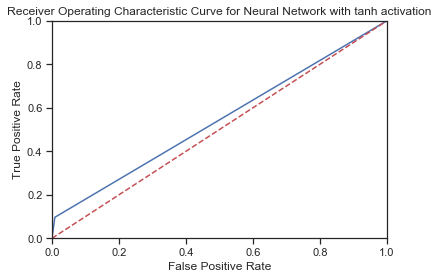


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Capital Loss ----------

0.003287792205810547 seconds for  Dummy Classifier that predicts most frequent  to train
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7437622142435123
Using Capital Loss as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


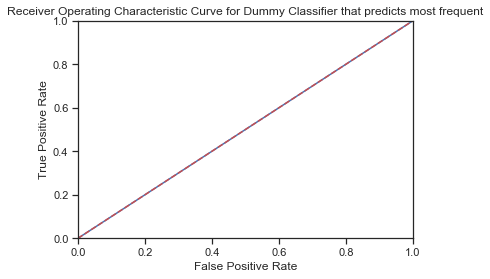


--------------- Returning Algorithm Results Summary for the feature: Hours Per Week ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Hours Per Week ----------

4.878525018692017 seconds for  SVM with Linear Kernel  to train
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7437622142435123
Using Hours Per Week as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


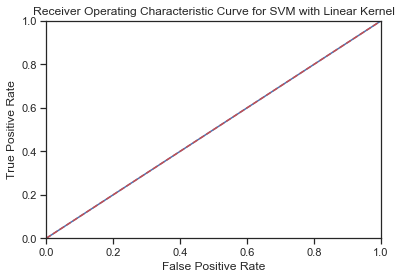


---------- Results Summary for SVM with Sigmoid Kernel for the column: Hours Per Week ----------

5.942314863204956 seconds for  SVM with Sigmoid Kernel  to train
Using Hours Per Week as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.6770894877971185
Using Hours Per Week as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7209090909090909

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3428        716
True >50k       1020        337

F1-score is: 0.2796680497925311


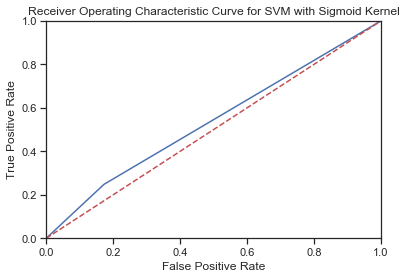


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Hours Per Week ----------

5.985067844390869 seconds for  SVM with Radial Basis Function Kernel  to train
Using Hours Per Week as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7437622142435123
Using Hours Per Week as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


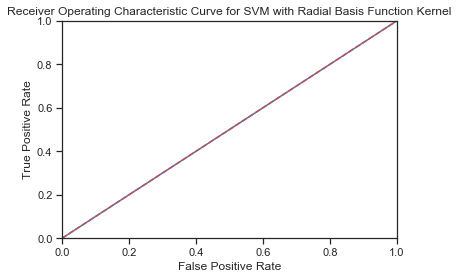


---------- Results Summary for Neural Network with ReLU activation for the column: Hours Per Week ----------

0.5473120212554932 seconds for  Neural Network with ReLU activation  to train
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7437622142435123
Using Hours Per Week as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


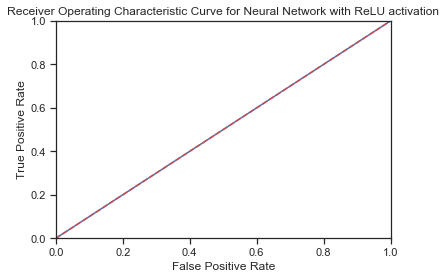


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Hours Per Week ----------

0.17034196853637695 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7437622142435123
Using Hours Per Week as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


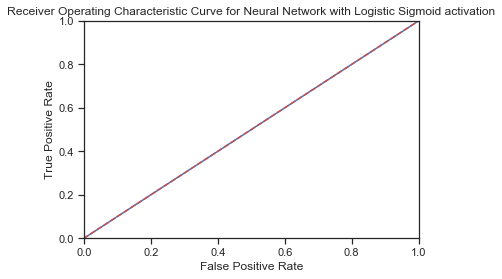


---------- Results Summary for Neural Network with tanh activation for the column: Hours Per Week ----------

0.17234182357788086 seconds for  Neural Network with tanh activation  to train
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7437622142435123
Using Hours Per Week as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


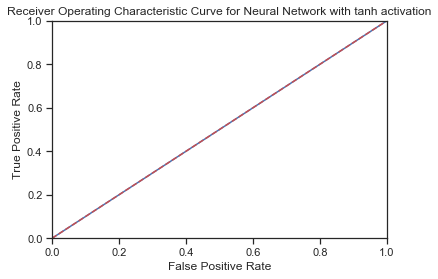


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Hours Per Week ----------

0.002179861068725586 seconds for  Dummy Classifier that predicts most frequent  to train
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7437622142435123
Using Hours Per Week as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


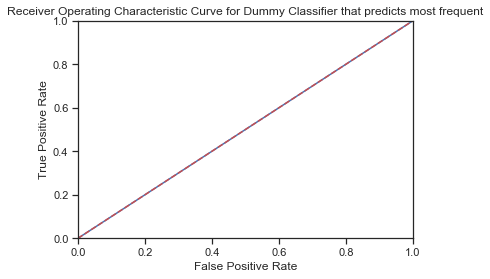


--------------- Returning Algorithm Results Summary for the feature: Workclass ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Workclass ----------

3.8545777797698975 seconds for  SVM with Linear Kernel  to train
Using Workclass as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7485797391264828
Using Workclass as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7627272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4064         80
True >50k       1258         99

F1-score is: 0.12890625000000003


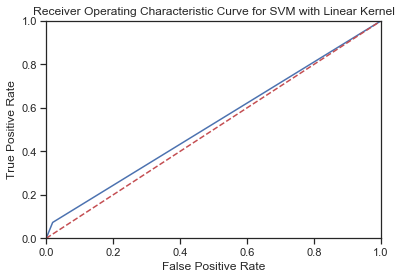


---------- Results Summary for SVM with Sigmoid Kernel for the column: Workclass ----------

7.037168979644775 seconds for  SVM with Sigmoid Kernel  to train
Using Workclass as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7485797391264828
Using Workclass as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7627272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4064         80
True >50k       1258         99

F1-score is: 0.12890625000000003


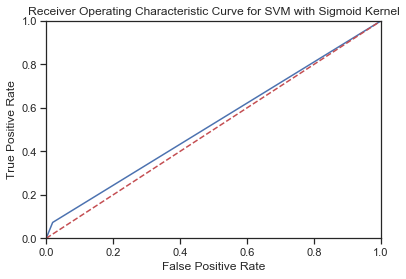


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Workclass ----------

6.8061511516571045 seconds for  SVM with Radial Basis Function Kernel  to train
Using Workclass as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7485797391264828
Using Workclass as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7627272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4064         80
True >50k       1258         99

F1-score is: 0.12890625000000003


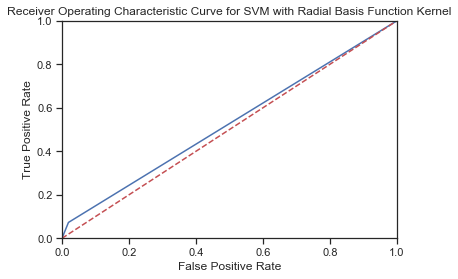


---------- Results Summary for Neural Network with ReLU activation for the column: Workclass ----------

0.06247711181640625 seconds for  Neural Network with ReLU activation  to train
Using Workclass as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7437622142435123
Using Workclass as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


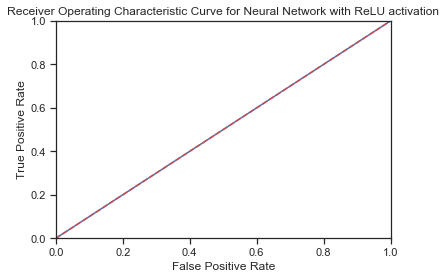


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Workclass ----------

0.26398205757141113 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7485797391264828
Using Workclass as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7567714960916198

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4064         80
True >50k       1258         99

F1-score is: 0.12890625000000003


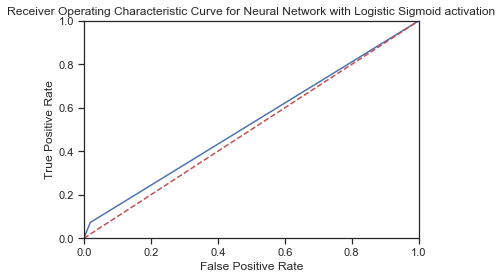


---------- Results Summary for Neural Network with tanh activation for the column: Workclass ----------

0.24661803245544434 seconds for  Neural Network with tanh activation  to train
Using Workclass as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7485797391264828
Using Workclass as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7567714960916198

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4064         80
True >50k       1258         99

F1-score is: 0.12890625000000003


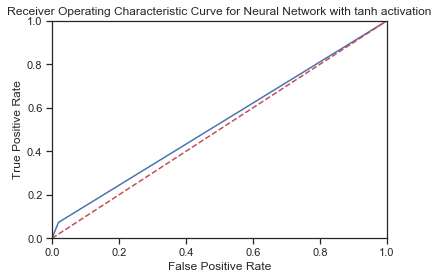


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Workclass ----------

0.0025177001953125 seconds for  Dummy Classifier that predicts most frequent  to train
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7437622142435123
Using Workclass as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


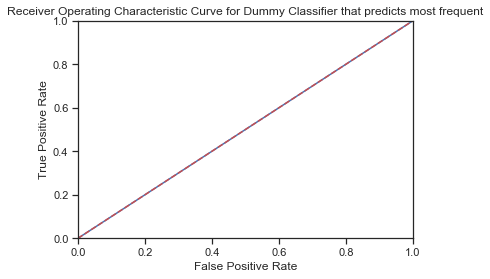


--------------- Returning Algorithm Results Summary for the feature: Marital Status ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Marital Status ----------

4.344418048858643 seconds for  SVM with Linear Kernel  to train
Using Marital Status as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7437622142435123
Using Marital Status as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


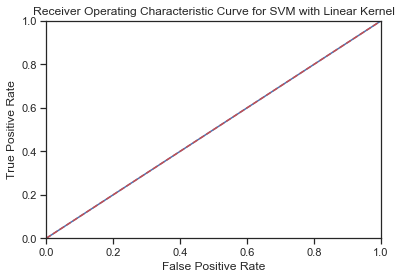


---------- Results Summary for SVM with Sigmoid Kernel for the column: Marital Status ----------

7.7421300411224365 seconds for  SVM with Sigmoid Kernel  to train
Using Marital Status as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7437622142435123
Using Marital Status as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


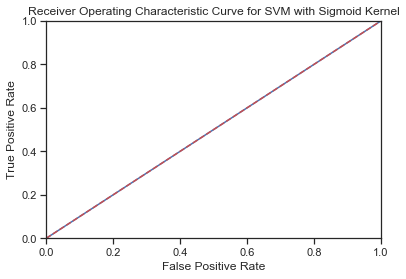


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Marital Status ----------

7.069656133651733 seconds for  SVM with Radial Basis Function Kernel  to train
Using Marital Status as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7437622142435123
Using Marital Status as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


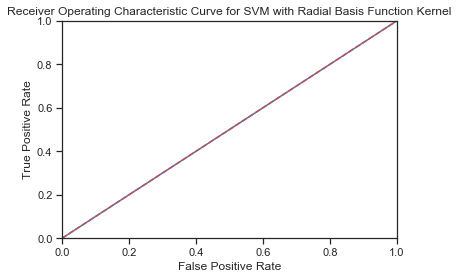


---------- Results Summary for Neural Network with ReLU activation for the column: Marital Status ----------

0.42791080474853516 seconds for  Neural Network with ReLU activation  to train
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7437622142435123
Using Marital Status as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7531357934920924

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4142          2
True >50k       1356          1

F1-score is: 0.0014705882352941176


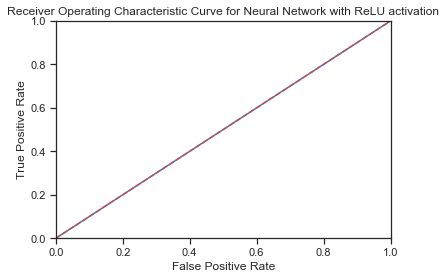


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Marital Status ----------

0.3444979190826416 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7437622142435123
Using Marital Status as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7531357934920924

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4142          2
True >50k       1356          1

F1-score is: 0.0014705882352941176


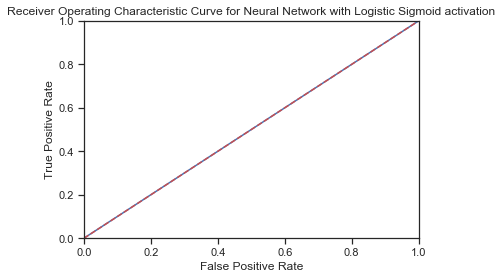


---------- Results Summary for Neural Network with tanh activation for the column: Marital Status ----------

0.319425106048584 seconds for  Neural Network with tanh activation  to train
Using Marital Status as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7437622142435123
Using Marital Status as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7531357934920924

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4142          2
True >50k       1356          1

F1-score is: 0.0014705882352941176


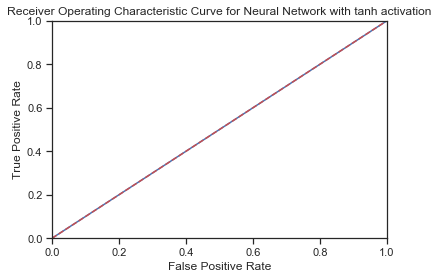


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Marital Status ----------

0.0023508071899414062 seconds for  Dummy Classifier that predicts most frequent  to train
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7437622142435123
Using Marital Status as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


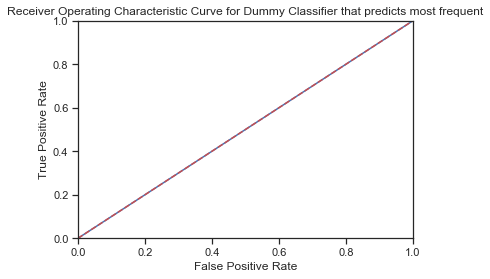


--------------- Returning Algorithm Results Summary for the feature: Occupation ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Occupation ----------

6.508805274963379 seconds for  SVM with Linear Kernel  to train
Using Occupation as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7437622142435123
Using Occupation as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


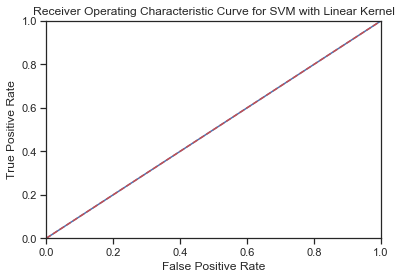


---------- Results Summary for SVM with Sigmoid Kernel for the column: Occupation ----------

7.95845103263855 seconds for  SVM with Sigmoid Kernel  to train
Using Occupation as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7437622142435123
Using Occupation as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


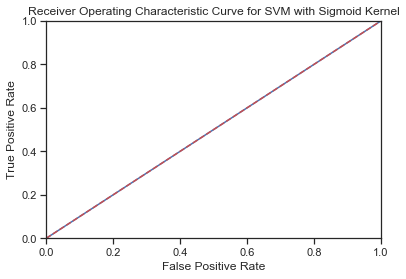


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Occupation ----------

9.563807964324951 seconds for  SVM with Radial Basis Function Kernel  to train
Using Occupation as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7437622142435123
Using Occupation as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


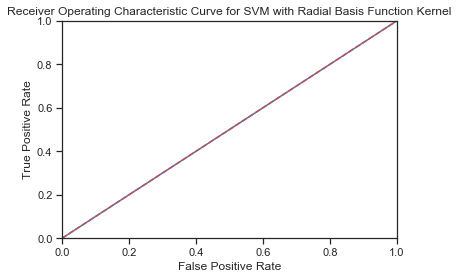


---------- Results Summary for Neural Network with ReLU activation for the column: Occupation ----------

0.4898200035095215 seconds for  Neural Network with ReLU activation  to train
Using Occupation as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7437622142435123
Using Occupation as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


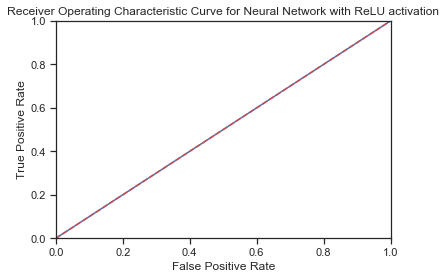


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Occupation ----------

0.34665822982788086 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7437622142435123
Using Occupation as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


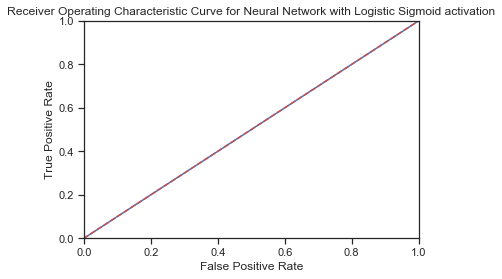


---------- Results Summary for Neural Network with tanh activation for the column: Occupation ----------

0.6192190647125244 seconds for  Neural Network with tanh activation  to train
Using Occupation as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7437622142435123
Using Occupation as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


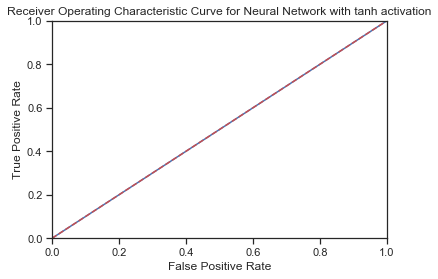


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Occupation ----------

0.0028700828552246094 seconds for  Dummy Classifier that predicts most frequent  to train
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7437622142435123
Using Occupation as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


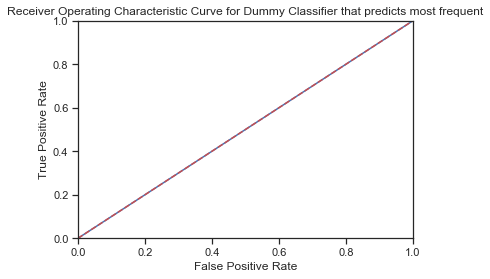


--------------- Returning Algorithm Results Summary for the feature: Relationship ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Relationship ----------

4.239330053329468 seconds for  SVM with Linear Kernel  to train
Using Relationship as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7447620778984684
Using Relationship as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4021        123
True >50k       1237        120

F1-score is: 0.14999999999999997


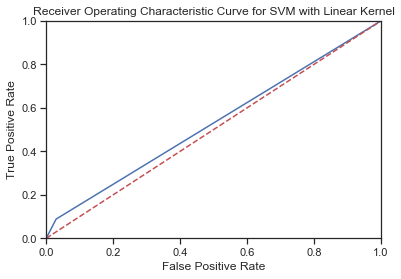


---------- Results Summary for SVM with Sigmoid Kernel for the column: Relationship ----------

7.4627649784088135 seconds for  SVM with Sigmoid Kernel  to train
Using Relationship as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7447620778984684
Using Relationship as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4021        123
True >50k       1237        120

F1-score is: 0.14999999999999997


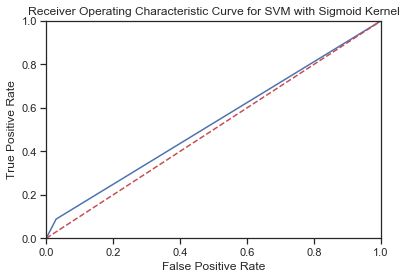


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Relationship ----------

7.023114919662476 seconds for  SVM with Radial Basis Function Kernel  to train
Using Relationship as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7447620778984684
Using Relationship as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4021        123
True >50k       1237        120

F1-score is: 0.14999999999999997


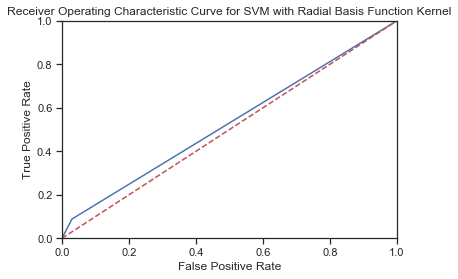


---------- Results Summary for Neural Network with ReLU activation for the column: Relationship ----------

0.7862892150878906 seconds for  Neural Network with ReLU activation  to train
Using Relationship as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7447620778984684
Using Relationship as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7527722232321397

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4021        123
True >50k       1237        120

F1-score is: 0.14999999999999997


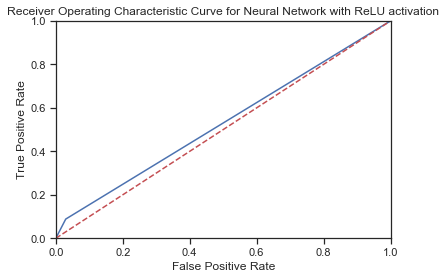


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Relationship ----------

0.3999059200286865 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7447620778984684
Using Relationship as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7527722232321397

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4021        123
True >50k       1237        120

F1-score is: 0.14999999999999997


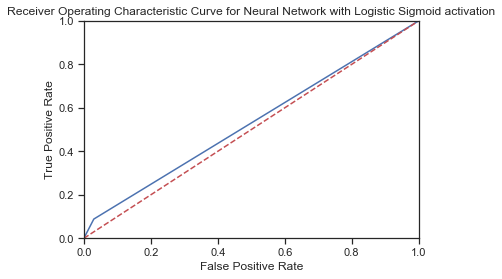


---------- Results Summary for Neural Network with tanh activation for the column: Relationship ----------

0.3160519599914551 seconds for  Neural Network with tanh activation  to train
Using Relationship as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7447620778984684
Using Relationship as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7527722232321397

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4021        123
True >50k       1237        120

F1-score is: 0.14999999999999997


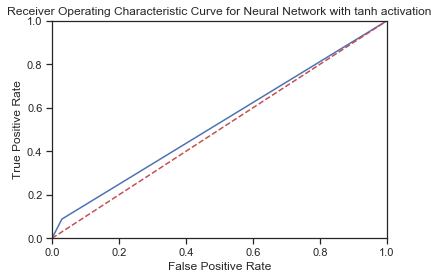


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Relationship ----------

0.0019669532775878906 seconds for  Dummy Classifier that predicts most frequent  to train
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7437622142435123
Using Relationship as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


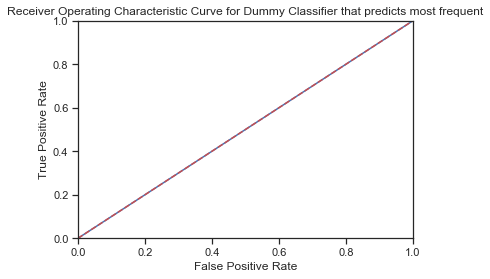


--------------- Returning Algorithm Results Summary for the feature: Race ---------------

---------- Results Summary for SVM with Linear Kernel for the column: Race ----------

3.116575002670288 seconds for  SVM with Linear Kernel  to train
Using Race as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.7437622142435123
Using Race as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


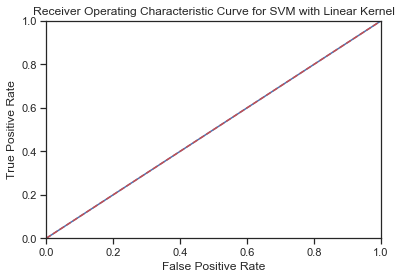


---------- Results Summary for SVM with Sigmoid Kernel for the column: Race ----------

5.217680931091309 seconds for  SVM with Sigmoid Kernel  to train
Using Race as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7437622142435123
Using Race as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


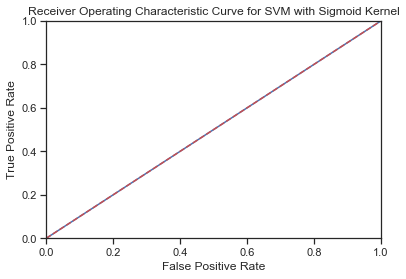


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: Race ----------

4.388660907745361 seconds for  SVM with Radial Basis Function Kernel  to train
Using Race as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.7437622142435123
Using Race as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.7536363636363637

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


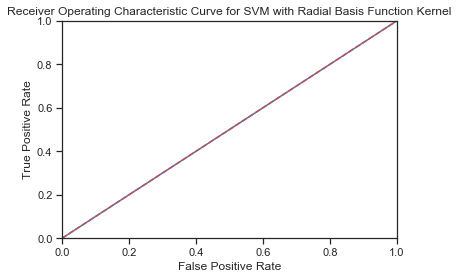


---------- Results Summary for Neural Network with ReLU activation for the column: Race ----------

0.170640230178833 seconds for  Neural Network with ReLU activation  to train
Using Race as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.7437622142435123
Using Race as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


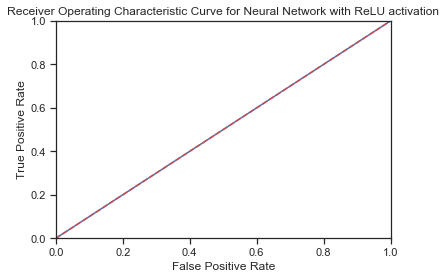


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: Race ----------

0.2403850555419922 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.7437622142435123
Using Race as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


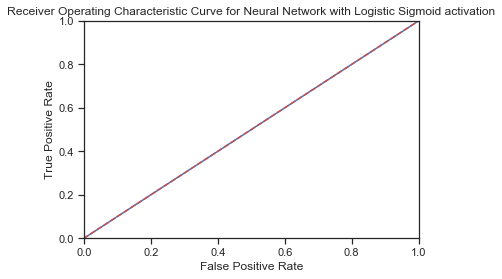


---------- Results Summary for Neural Network with tanh activation for the column: Race ----------

0.15561914443969727 seconds for  Neural Network with tanh activation  to train
Using Race as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.7437622142435123
Using Race as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


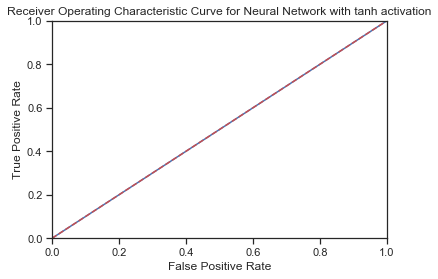


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: Race ----------

0.0021657943725585938 seconds for  Dummy Classifier that predicts most frequent  to train
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7437622142435123
Using Race as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


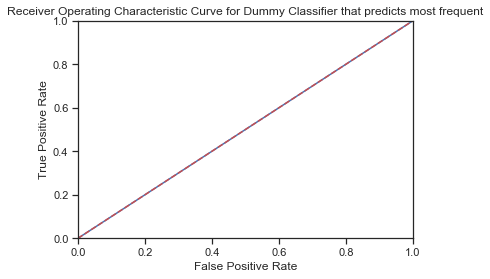


--------------- Returning Algorithm Results Summary for the feature: All Columns ---------------

---------- Results Summary for SVM with Linear Kernel for the column: All Columns ----------

24.022803783416748 seconds for  SVM with Linear Kernel  to train
Using All Columns as a predictor for  SVM with Linear Kernel  we get train accuracy of:  0.8461573421806118
Using All Columns as a predictor for  SVM with Linear Kernel  we get test accuracy of:  0.85

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3850        294
True >50k        569        788

F1-score is: 0.6461664616646167


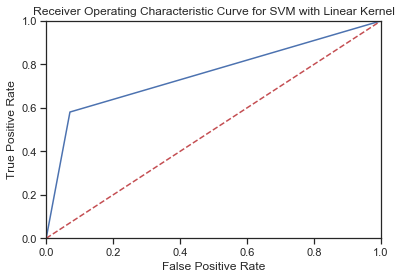


---------- Results Summary for SVM with Sigmoid Kernel for the column: All Columns ----------

28.699309825897217 seconds for  SVM with Sigmoid Kernel  to train
Using All Columns as a predictor for  SVM with Sigmoid Kernel  we get train accuracy of:  0.7793028223424079
Using All Columns as a predictor for  SVM with Sigmoid Kernel  we get test accuracy of:  0.8127272727272727

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3545        599
True >50k        605        752

F1-score is: 0.5553914327917282


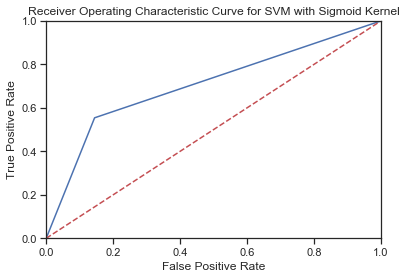


---------- Results Summary for SVM with Radial Basis Function Kernel for the column: All Columns ----------

19.37322497367859 seconds for  SVM with Radial Basis Function Kernel  to train
Using All Columns as a predictor for  SVM with Radial Basis Function Kernel  we get train accuracy of:  0.853020042721447
Using All Columns as a predictor for  SVM with Radial Basis Function Kernel  we get test accuracy of:  0.8454545454545455

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3861        283
True >50k        562        795

F1-score is: 0.6529774127310062


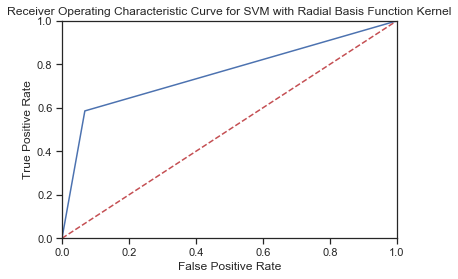


---------- Results Summary for Neural Network with ReLU activation for the column: All Columns ----------

1.4526197910308838 seconds for  Neural Network with ReLU activation  to train
Using All Columns as a predictor for  Neural Network with ReLU activation  we get train accuracy of:  0.8538835613325456
Using All Columns as a predictor for  Neural Network with ReLU activation  we get test accuracy of:  0.8509361934193783

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3844        300
True >50k        520        837

F1-score is: 0.6712109061748196


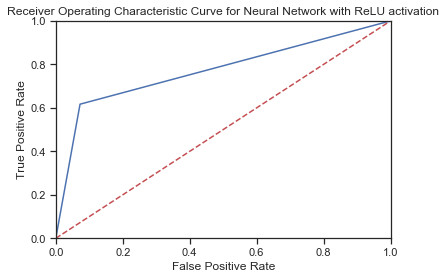


---------- Results Summary for Neural Network with Logistic Sigmoid activation for the column: All Columns ----------

1.546494960784912 seconds for  Neural Network with Logistic Sigmoid activation  to train
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get train accuracy of:  0.8532472844612098
Using All Columns as a predictor for  Neural Network with Logistic Sigmoid activation  we get test accuracy of:  0.846391565169969

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3826        318
True >50k        527        830

F1-score is: 0.6626746506986028


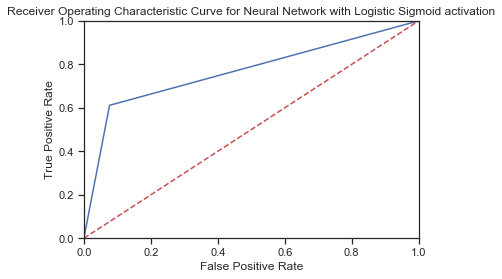


---------- Results Summary for Neural Network with tanh activation for the column: All Columns ----------

1.3787801265716553 seconds for  Neural Network with tanh activation  to train
Using All Columns as a predictor for  Neural Network with tanh activation  we get train accuracy of:  0.8538835613325456
Using All Columns as a predictor for  Neural Network with tanh activation  we get test accuracy of:  0.850754408289402

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       3859        285
True >50k        536        821

F1-score is: 0.6666666666666666


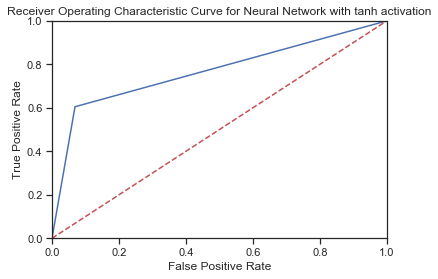


---------- Results Summary for Dummy Classifier that predicts most frequent for the column: All Columns ----------

0.004258871078491211 seconds for  Dummy Classifier that predicts most frequent  to train
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get train accuracy of:  0.7437622142435123
Using All Columns as a predictor for  Dummy Classifier that predicts most frequent  we get test accuracy of:  0.7533175786220687

Confusion Matrix: 
           Pred <50k  Pred >50k
True <50k       4144          0
True >50k       1357          0

F1-score is: 0.0


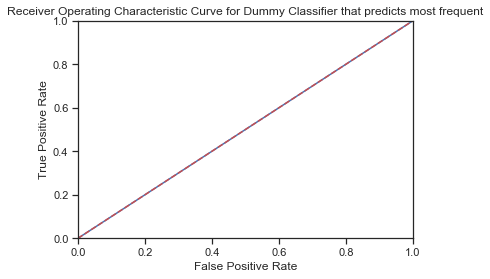

In [24]:
Y = np.array(new_df.iloc[:,45:46]) #labels
num_training = int(0.8*Y.shape[0])  #80% of the data for training
sc = StandardScaler()

for i in range(len(ranges)):
    print('--------------- Returning Algorithm Results Summary for the feature:',columns[i],'---------------')
    print()
    for j in range(len(classifiers)):
        if j == 0 or j == 1 or j == 2:   # if it is svm do cross validation
            return_results(classifiers[j],names[j],True,False,i)
        elif j == 6:  # if it is a dummyclassifier, calculate accuracy the proper way
            return_results(classifiers[j],names[j],False,True,i)  
        else:    # if a regular classifier, just do the normal operations
            return_results(classifiers[j],names[j],False,False,i)

## How to cope with unbalanced data
